<a href="https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/notebooks%20/5_transfer_learning/finetune_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2 Oxford 102 Flowers datast

In this notebook we try to compare the accuracy of a model trained from scratch on the Oxford 102 Flowers dataset, vs a model pretrained on imagenet and finetuned.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import requests
import tarfile
import shutil
from PIL import Image
from scipy.io import loadmat

### FlowerClassifier Class Definition
I have decided to implement a custom class to deal with the training and data management. You could use pytorch-lightning instead, or define functions without classes


In [2]:
# FlowerClassifier Class Definition
class FlowerClassifier:
    def __init__(self, data_dir='oxford_flowers'):
        self.data_dir = Path(data_dir)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.initialize_transforms()

    def initialize_transforms(self):
        """Initialize data transforms for training and validation"""
        self.data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224), #Imagenet uses 224 pixel images, so we want to keep the same size
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }

# Dataset Download and Preparation Methods
    def download_dataset(self):
        """Download and prepare the Oxford 102 Flower Dataset"""
        if not self.data_dir.exists():
            self.data_dir.mkdir(parents=True)

        # Download URLs
        urls = {
            'images': "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz",
            'labels': "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat",
            'splits': "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat"
        }

        # Download files
        files = {}
        for name, url in urls.items():
            print(f"Downloading {name}...")
            response = requests.get(url, stream=True)
            response.raise_for_status()
            file_path = self.data_dir / f"{name}.tgz" if name == 'images' else self.data_dir / f"{name}.mat"
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            files[name] = file_path

        # Extract images
        print("Extracting images...")
        with tarfile.open(files['images'], 'r:gz') as tar:
            tar.extractall(path=self.data_dir)

        # Process dataset
        labels = loadmat(str(files['labels']))['labels'][0]
        splits = loadmat(str(files['splits']))

        # Organize into train/val/test
        print("Organizing dataset...")
        split_data = {
            'train': splits['trnid'][0],
            'val': splits['valid'][0],
            'test': splits['tstid'][0]
        }

        for split_name, split_ids in split_data.items():
            split_dir = self.data_dir / split_name
            if split_dir.exists():
                shutil.rmtree(split_dir)

            for class_id in range(1, 103):
                (split_dir / str(class_id)).mkdir(parents=True, exist_ok=True)

            for idx in split_ids:
                img_name = f'image_{idx:05d}.jpg'
                src_path = self.data_dir / 'jpg' / img_name
                dst_path = split_dir / str(labels[idx-1]) / img_name
                shutil.copy2(src_path, dst_path)

        # Cleanup
        print("Cleaning up...")
        for file in files.values():
            file.unlink()
        shutil.rmtree(self.data_dir / 'jpg')
        print("Dataset preparation completed!")

# Data Loading Methods
    def load_data(self):
        """Load and prepare datasets"""
        self.image_datasets = {
            x: datasets.ImageFolder(str(self.data_dir / x), self.data_transforms[x])
            for x in ['train', 'val']
        }

        self.dataloaders = {
            x: DataLoader(self.image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
            for x in ['train', 'val']
        }

        self.dataset_sizes = {x: len(self.image_datasets[x]) for x in ['train', 'val']}
        self.class_names = self.image_datasets['train'].classes

        print(f"Dataset sizes: Train: {self.dataset_sizes['train']}, Val: {self.dataset_sizes['val']}")
        print(f"Number of classes: {len(self.class_names)}")

# Model Setup and Training Methods
    def setup_model(self, pretrained=True, lr=0.001):
        """Initialize and setup the model"""
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, len(self.class_names))
        model = model.to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        return model, criterion, optimizer, scheduler

    def train_model(self, model, criterion, optimizer, scheduler, num_epochs=25, model_name=""):
        """Train the model and return results"""
        best_acc = 0.0
        best_model_wts = None
        metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 20)

            for phase in ['train', 'val']:
                model.train() if phase == 'train' else model.eval()
                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in tqdm(self.dataloaders[phase], desc=phase):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / self.dataset_sizes[phase]
                epoch_acc = running_corrects.double() / self.dataset_sizes[phase]

                metrics[f'{phase}_loss'].append(epoch_loss)
                metrics[f'{phase}_acc'].append(epoch_acc.cpu())

                print(f'{phase.capitalize()} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict().copy()
                    print(f'New best validation accuracy: {epoch_acc:.4f}')

            if phase == 'train':
                scheduler.step()

        self.plot_training_metrics(metrics, model_name)
        model.load_state_dict(best_model_wts)
        return model, best_acc

# Visualization Methods
    @staticmethod
    def plot_training_metrics(metrics, model_name):
        """Plot training and validation metrics"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(metrics['train_loss'], label='Training Loss')
        plt.plot(metrics['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss ({model_name})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(metrics['train_acc'], label='Training Accuracy')
        plt.plot(metrics['val_acc'], label='Validation Accuracy')
        plt.title(f'Model Accuracy ({model_name})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def visualize_predictions(self, model, num_images=6):
        """Visualize model predictions"""
        model.eval()
        images, labels = next(iter(self.dataloaders['val']))
        images = images.to(self.device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        plt.figure(figsize=(15, 10))
        for idx in range(min(num_images, len(images))):
            plt.subplot(2, 3, idx + 1)
            self.imshow(images[idx])
            color = 'green' if preds[idx] == labels[idx] else 'red'
            plt.title(f'Pred: {self.class_names[preds[idx]]}\nTrue: {self.class_names[labels[idx]]}',
                     color=color)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def imshow(inp):
        """Display image for Tensor"""
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)


### Main execution
We will run one experiment using the model initialized with random weights (trained from scratch), and an experiment using pre-trained weights (finetuning).

We first prepare the data

In [3]:
classifier = FlowerClassifier()

# Download and prepare dataset
classifier.download_dataset()
classifier.load_data()

Extracting images...
Organizing dataset...
Cleaning up...
Dataset preparation completed!
Dataset sizes: Train: 1020, Val: 1020
Number of classes: 102


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Then we run the training from scratch experiment


Training ResNet18 from scratch...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


Train - Loss: 4.7653, Accuracy: 0.0225


val: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


Val - Loss: 6.0638, Accuracy: 0.0539
New best validation accuracy: 0.0539

Epoch 2/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


Train - Loss: 4.1041, Accuracy: 0.0480


val: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


Val - Loss: 4.5847, Accuracy: 0.0588
New best validation accuracy: 0.0588

Epoch 3/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s]


Train - Loss: 3.8945, Accuracy: 0.0716


val: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


Val - Loss: 4.3745, Accuracy: 0.0686
New best validation accuracy: 0.0686

Epoch 4/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Train - Loss: 3.7759, Accuracy: 0.0912


val: 100%|██████████| 32/32 [00:05<00:00,  5.54it/s]


Val - Loss: 4.0728, Accuracy: 0.0696
New best validation accuracy: 0.0696

Epoch 5/25
--------------------


train: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


Train - Loss: 3.6745, Accuracy: 0.0990


val: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


Val - Loss: 4.0827, Accuracy: 0.0990
New best validation accuracy: 0.0990

Epoch 6/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Train - Loss: 3.5710, Accuracy: 0.0922


val: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]


Val - Loss: 3.9543, Accuracy: 0.1078
New best validation accuracy: 0.1078

Epoch 7/25
--------------------


train: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Train - Loss: 3.5008, Accuracy: 0.1343


val: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


Val - Loss: 3.8653, Accuracy: 0.1324
New best validation accuracy: 0.1324

Epoch 8/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Train - Loss: 3.3375, Accuracy: 0.1618


val: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


Val - Loss: 3.6841, Accuracy: 0.1206

Epoch 9/25
--------------------


train: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


Train - Loss: 3.3586, Accuracy: 0.1588


val: 100%|██████████| 32/32 [00:05<00:00,  5.54it/s]


Val - Loss: 3.3430, Accuracy: 0.1863
New best validation accuracy: 0.1863

Epoch 10/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


Train - Loss: 3.2207, Accuracy: 0.1755


val: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


Val - Loss: 3.4572, Accuracy: 0.1873
New best validation accuracy: 0.1873

Epoch 11/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Train - Loss: 3.1733, Accuracy: 0.1824


val: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


Val - Loss: 3.3148, Accuracy: 0.2029
New best validation accuracy: 0.2029

Epoch 12/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Train - Loss: 3.0332, Accuracy: 0.1902


val: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


Val - Loss: 3.6230, Accuracy: 0.1657

Epoch 13/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.57it/s]


Train - Loss: 3.0887, Accuracy: 0.2147


val: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


Val - Loss: 4.1743, Accuracy: 0.1265

Epoch 14/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


Train - Loss: 2.9981, Accuracy: 0.2020


val: 100%|██████████| 32/32 [00:06<00:00,  4.74it/s]


Val - Loss: 3.3169, Accuracy: 0.2088
New best validation accuracy: 0.2088

Epoch 15/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


Train - Loss: 2.9643, Accuracy: 0.2294


val: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


Val - Loss: 3.3260, Accuracy: 0.2108
New best validation accuracy: 0.2108

Epoch 16/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Train - Loss: 2.9966, Accuracy: 0.2088


val: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


Val - Loss: 3.1582, Accuracy: 0.2422
New best validation accuracy: 0.2422

Epoch 17/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


Train - Loss: 2.9404, Accuracy: 0.2127


val: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


Val - Loss: 3.5058, Accuracy: 0.1794

Epoch 18/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Train - Loss: 2.8331, Accuracy: 0.2559


val: 100%|██████████| 32/32 [00:05<00:00,  5.35it/s]


Val - Loss: 3.3573, Accuracy: 0.2314

Epoch 19/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


Train - Loss: 2.7557, Accuracy: 0.2588


val: 100%|██████████| 32/32 [00:05<00:00,  5.75it/s]


Val - Loss: 3.3929, Accuracy: 0.2216

Epoch 20/25
--------------------


train: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


Train - Loss: 2.7804, Accuracy: 0.2578


val: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s]


Val - Loss: 3.0377, Accuracy: 0.2578
New best validation accuracy: 0.2578

Epoch 21/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Train - Loss: 2.7155, Accuracy: 0.2745


val: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


Val - Loss: 3.1511, Accuracy: 0.2843
New best validation accuracy: 0.2843

Epoch 22/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


Train - Loss: 2.6376, Accuracy: 0.2922


val: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


Val - Loss: 2.9860, Accuracy: 0.2892
New best validation accuracy: 0.2892

Epoch 23/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


Train - Loss: 2.6014, Accuracy: 0.2980


val: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


Val - Loss: 3.8052, Accuracy: 0.2127

Epoch 24/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s]


Train - Loss: 2.6153, Accuracy: 0.2912


val: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s]


Val - Loss: 3.2175, Accuracy: 0.2382

Epoch 25/25
--------------------


train: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


Train - Loss: 2.6396, Accuracy: 0.2951


val: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


Val - Loss: 2.7775, Accuracy: 0.3069
New best validation accuracy: 0.3069


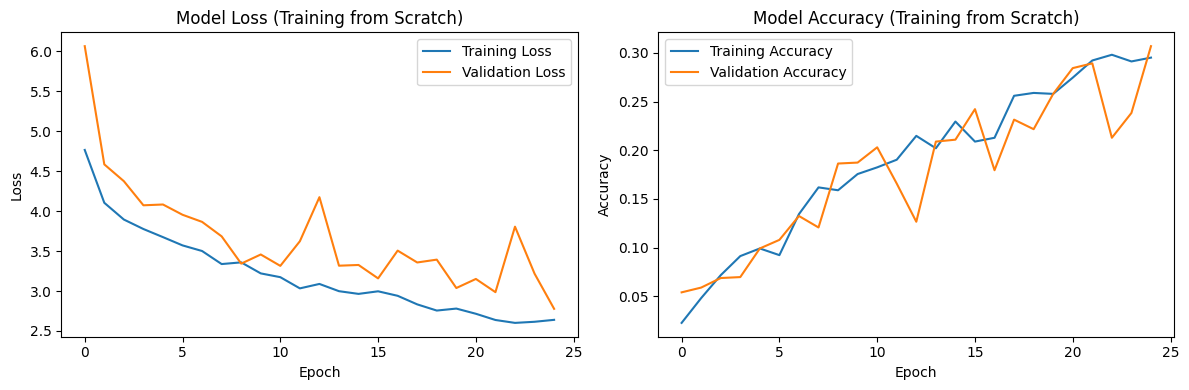

In [4]:
# Train from scratch
print("\nTraining ResNet18 from scratch...")
model_scratch, criterion, optimizer, scheduler = classifier.setup_model(
    pretrained=False, lr=0.001
)
model_scratch, acc_scratch = classifier.train_model(
    model_scratch, criterion, optimizer, scheduler,
    num_epochs=25, model_name="Training from Scratch"
)


After that, we run the finetuning experiment


Fine-tuning pretrained ResNet18...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Train - Loss: 4.4282, Accuracy: 0.0696


val: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


Val - Loss: 3.5360, Accuracy: 0.2794
New best validation accuracy: 0.2794

Epoch 2/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


Train - Loss: 3.3414, Accuracy: 0.4000


val: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


Val - Loss: 2.4096, Accuracy: 0.5676
New best validation accuracy: 0.5676

Epoch 3/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


Train - Loss: 2.5234, Accuracy: 0.6186


val: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


Val - Loss: 1.9097, Accuracy: 0.6961
New best validation accuracy: 0.6961

Epoch 4/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


Train - Loss: 2.0029, Accuracy: 0.7392


val: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


Val - Loss: 1.4954, Accuracy: 0.7804
New best validation accuracy: 0.7804

Epoch 5/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


Train - Loss: 1.5799, Accuracy: 0.8167


val: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s]


Val - Loss: 1.1537, Accuracy: 0.8255
New best validation accuracy: 0.8255

Epoch 6/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


Train - Loss: 1.3118, Accuracy: 0.8422


val: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


Val - Loss: 1.0395, Accuracy: 0.8441
New best validation accuracy: 0.8441

Epoch 7/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Train - Loss: 1.0168, Accuracy: 0.8922


val: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


Val - Loss: 0.9254, Accuracy: 0.8598
New best validation accuracy: 0.8598

Epoch 8/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


Train - Loss: 0.8949, Accuracy: 0.8971


val: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


Val - Loss: 0.8051, Accuracy: 0.8784
New best validation accuracy: 0.8784

Epoch 9/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Train - Loss: 0.7239, Accuracy: 0.9255


val: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


Val - Loss: 0.7011, Accuracy: 0.8961
New best validation accuracy: 0.8961

Epoch 10/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


Train - Loss: 0.6857, Accuracy: 0.9216


val: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]


Val - Loss: 0.6651, Accuracy: 0.9010
New best validation accuracy: 0.9010

Epoch 11/25
--------------------


train: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


Train - Loss: 0.5777, Accuracy: 0.9333


val: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


Val - Loss: 0.6080, Accuracy: 0.9078
New best validation accuracy: 0.9078

Epoch 12/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Train - Loss: 0.4795, Accuracy: 0.9569


val: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


Val - Loss: 0.6022, Accuracy: 0.9069

Epoch 13/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Train - Loss: 0.4473, Accuracy: 0.9510


val: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


Val - Loss: 0.5937, Accuracy: 0.9039

Epoch 14/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


Train - Loss: 0.4092, Accuracy: 0.9520


val: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


Val - Loss: 0.5086, Accuracy: 0.9235
New best validation accuracy: 0.9235

Epoch 15/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


Train - Loss: 0.3389, Accuracy: 0.9667


val: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s]


Val - Loss: 0.4983, Accuracy: 0.9118

Epoch 16/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Train - Loss: 0.3436, Accuracy: 0.9618


val: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


Val - Loss: 0.5267, Accuracy: 0.9059

Epoch 17/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


Train - Loss: 0.3085, Accuracy: 0.9559


val: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


Val - Loss: 0.5303, Accuracy: 0.9078

Epoch 18/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


Train - Loss: 0.3254, Accuracy: 0.9510


val: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


Val - Loss: 0.5075, Accuracy: 0.9118

Epoch 19/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Train - Loss: 0.3047, Accuracy: 0.9520


val: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


Val - Loss: 0.4916, Accuracy: 0.9078

Epoch 20/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


Train - Loss: 0.2573, Accuracy: 0.9627


val: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s]


Val - Loss: 0.4543, Accuracy: 0.9186

Epoch 21/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


Train - Loss: 0.2156, Accuracy: 0.9716


val: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


Val - Loss: 0.4634, Accuracy: 0.9196

Epoch 22/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


Train - Loss: 0.2082, Accuracy: 0.9696


val: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


Val - Loss: 0.4633, Accuracy: 0.9118

Epoch 23/25
--------------------


train: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


Train - Loss: 0.2485, Accuracy: 0.9667


val: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


Val - Loss: 0.4171, Accuracy: 0.9265
New best validation accuracy: 0.9265

Epoch 24/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Train - Loss: 0.2278, Accuracy: 0.9627


val: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s]


Val - Loss: 0.4570, Accuracy: 0.9098

Epoch 25/25
--------------------


train: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


Train - Loss: 0.2326, Accuracy: 0.9627


val: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s]


Val - Loss: 0.4427, Accuracy: 0.9088


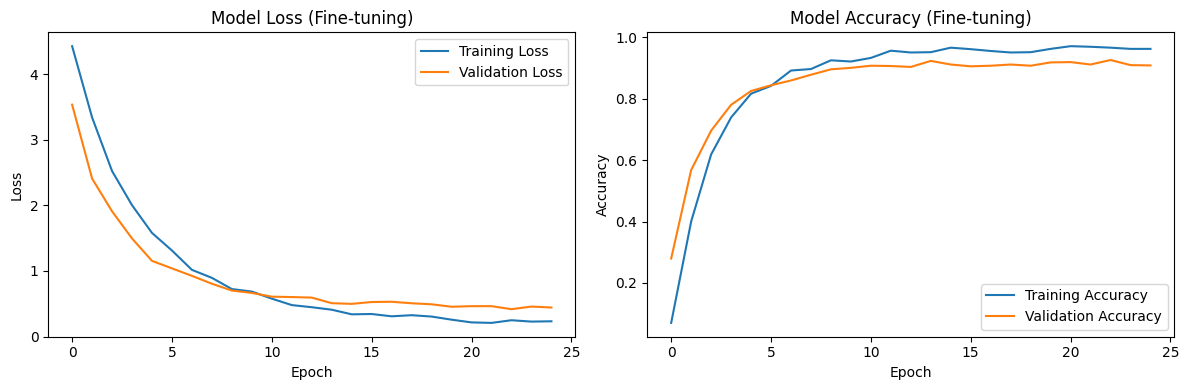

In [5]:
# Fine-tuning
print("\nFine-tuning pretrained ResNet18...")
model_finetune, criterion, optimizer, scheduler = classifier.setup_model(
    pretrained=True, lr=0.0001
)
model_finetune, acc_finetune = classifier.train_model(
    model_finetune, criterion, optimizer, scheduler,
    num_epochs=25, model_name="Fine-tuning"
)

And we comapre results


Final Results:
Training from scratch - Best validation accuracy: 0.3069
Fine-tuning - Best validation accuracy: 0.9265

Visualizing predictions from model trained from scratch...


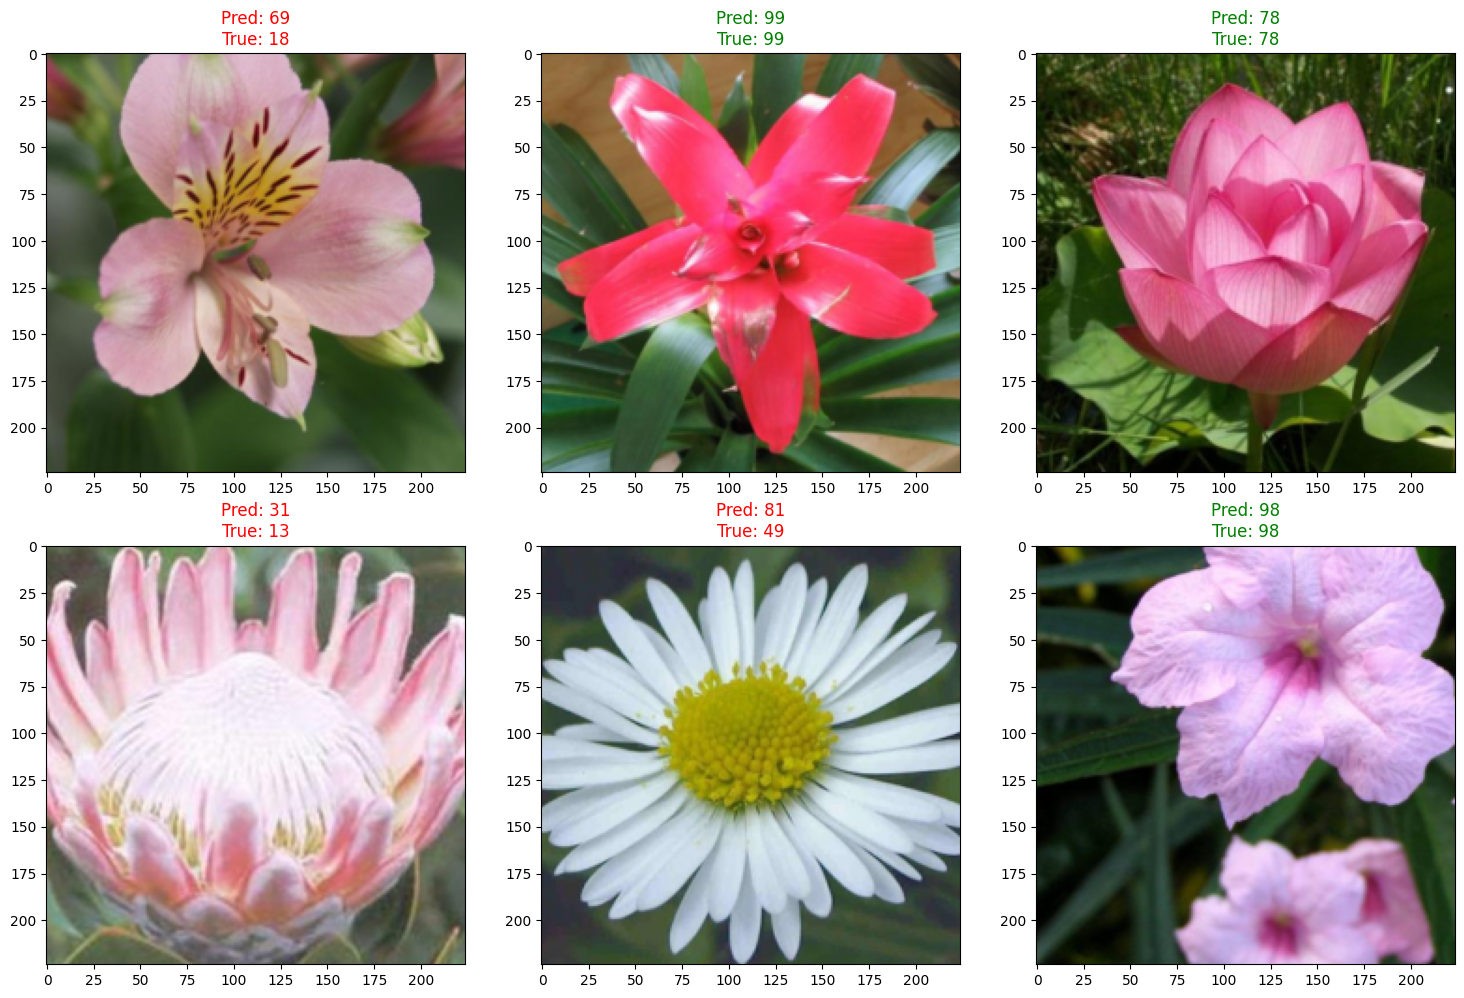


+++++++++++++++++++++++++++++++++++

Visualizing predictions from fine-tuned model...


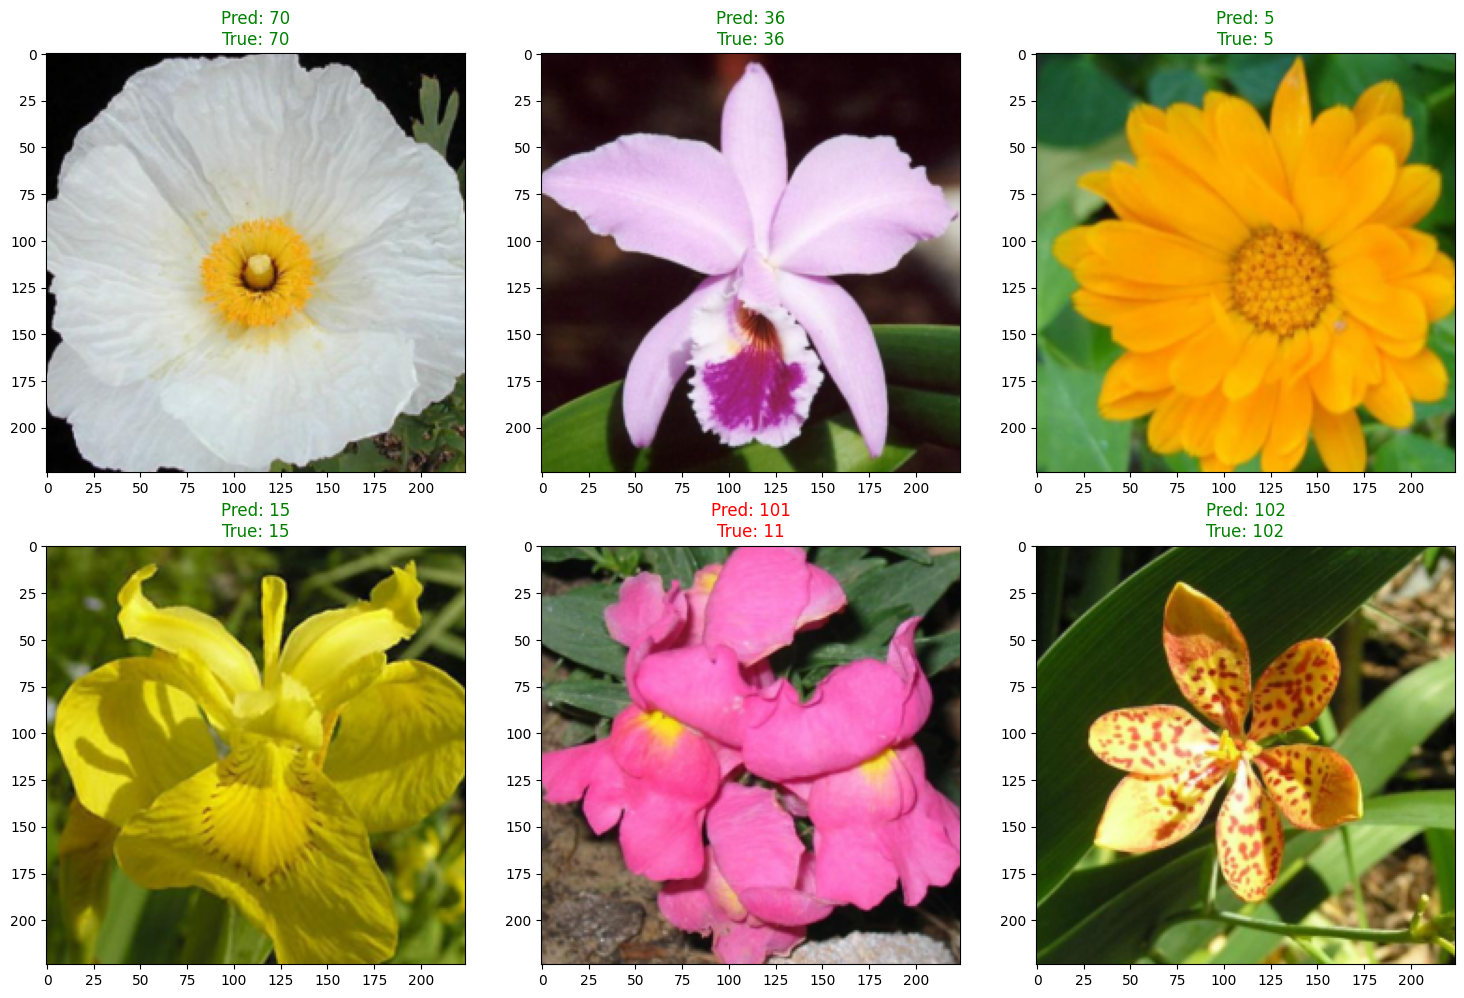


Both models saved!


In [8]:
# Compare results
print("\nFinal Results:")
print(f"Training from scratch - Best validation accuracy: {acc_scratch:.4f}")
print(f"Fine-tuning - Best validation accuracy: {acc_finetune:.4f}")

# Visualize predictions
print("\nVisualizing predictions from model trained from scratch...")
classifier.visualize_predictions(model_scratch)
print("\n+++++++++++++++++++++++++++++++++++\n\nVisualizing predictions from fine-tuned model...")
classifier.visualize_predictions(model_finetune)

# Save models
torch.save(model_scratch.state_dict(), 'flower_classifier_scratch.pth')
torch.save(model_finetune.state_dict(), 'flower_classifier_finetune.pth')
print("\nBoth models saved!")
